In [1]:
import pandas as pd
import numpy as np
import os
os.chdir('../')
import matplotlib.pyplot as plt
from kernel import utils, data_processing, modelling

# 1. Load Training Data

In [2]:
df = pd.read_csv('./data/clf_train.csv').pipe(utils.detect_id_col)
df_inf = pd.read_csv('./data/clf_test.csv')
df.head()

Found id col: PassengerId
Set PassengerId as index column


,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# 2. Obtain Features

In [3]:
df_fea, labels = utils.split_feature_target(df, 'Survived')
df_fea.head()

,Pclass,SibSp,Sex,Age,Ticket,Cabin,Parch,Fare,Name,Embarked
PassengerId,,,,,,,,,,
1,3,1,male,22.0,A/5 21171,NaN,0,7.2500,"Braund, Mr. Owen Harris",S
2,1,1,female,38.0,PC 17599,C85,0,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",C
3,3,0,female,26.0,STON/O2. 3101282,NaN,0,7.9250,"Heikkinen, Miss. Laina",S
4,1,1,female,35.0,113803,C123,0,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",S
5,3,0,male,35.0,373450,NaN,0,8.0500,"Allen, Mr. William Henry",S


In [4]:
df_fea.Name[-90:-60]

PassengerId
802          Collyer, Mrs. Harvey (Charlotte Annie Tate)
803                  Carter, Master. William Thornton II
804                      Thomas, Master. Assad Alexander
805                              Hedman, Mr. Oskar Arvid
806                            Johansson, Mr. Karl Johan
807                               Andrews, Mr. Thomas Jr
808                      Pettersson, Miss. Ellen Natalia
809                                    Meyer, Mr. August
810       Chambers, Mrs. Norman Campbell (Bertha Griggs)
811                               Alexander, Mr. William
812                                    Lester, Mr. James
813                            Slemen, Mr. Richard James
814                   Andersson, Miss. Ebba Iris Alfrida
815                           Tomlin, Mr. Ernest Portage
816                                     Fry, Mr. Richard
817                         Heininen, Miss. Wendla Maria
818                                   Mallet, Mr. Albert
819                

In [5]:
df_fea['cabin_class'] = df_fea.Cabin.str.slice(0, 1)
df_fea['Pclass'] = df_fea['Pclass'].astype(str)
df_inf['cabin_class'] = df_inf.Cabin.str.slice(0, 1)
df_inf['Pclass'] = df_inf['Pclass'].astype(str)

In [6]:
df_fea.drop(['Ticket', 'Name', 'Cabin'], axis=1, inplace=True)

In [7]:
dp = data_processing.DataProcessor(df_fea, 'titanic', True, 15)

All encoders saved.
All numeric medians saved.
Scaler saved.


In [8]:
X, y = dp.data.values, labels.values

In [9]:
X.shape

(891, 22)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:    1.7s


training score: 0.8298555377207063
testing score: 0.7873134328358209
{'solver': 'lbfgs', 'penalty': 'l2', 'max_iter': 2000, 'fit_intercept': False, 'class_weight': None, 'C': 5.0}
AUC: 0.8189826655299801


[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    2.0s finished


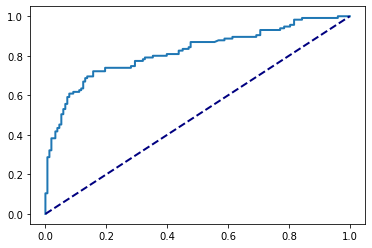

In [10]:
clf, params_lr, est_lr = modelling.train_lr_classifier(X, y, n_iter=30)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   31.4s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  1.4min finished


training score: 0.869983948635634
testing score: 0.7649253731343284
{'n_estimators': 200, 'min_samples_split': 20, 'min_samples_leaf': 4, 'max_features': 'auto', 'max_depth': 8, 'criterion': 'gini', 'ccp_alpha': 0.0, 'bootstrap': False}
AUC: 0.8304347826086957


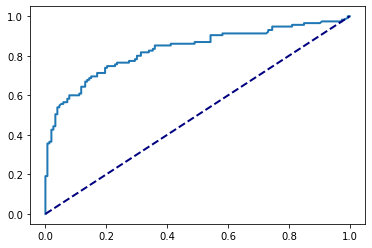

In [11]:
clf, params_rf, est_rf = modelling.train_rf_classifier(X, y, n_iter=30)

In [12]:
from sklearn.ensemble import VotingClassifier
rf = est_rf(**params_rf)
lr = est_lr(**params_lr)
model = VotingClassifier(estimators=[('lr', lr), ('rf', rf)], voting='hard')
model.fit(X, y)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=5.0, class_weight=None,
                                                 dual=False,
                                                 fit_intercept=False,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=2000,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=None,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('rf',
                              RandomForestClassifier(bootstrap=False,
                                                     ccp_alpha=0.0,
                                                     class_weight

In [13]:
# model = est(**params)
# model.fit(X, y)

In [14]:
df_inf['Survived'] = model.predict(dp.transform(df_inf).values)

In [15]:
df_inf = df_inf.reset_index().rename(columns={'passengerid': 'PassengerId'})
df_inf[['PassengerId', 'Survived']].to_csv('./data/inf.csv', index=False)

In [16]:
# df_inf[['PassengerId', 'Survived']]